In [ ]:
print("test")

test


In [ ]:
# Import libraries
import os
import cv2
import glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy import savetxt
from tensorflow import keras
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
labels = ['no_tumor', 'tumor']
class_map = {
    'no_tumor': 0,
    'tumor': 1,
    'no_tumor_test': 0,
    'tumor_test': 1
}

train_img = []
train_labels = []

test_img = []
test_labels = []

path_train = '/content/drive/My Drive/tumor1/train'
path_test = '/content/drive/My Drive/tumor1/test'

img_size = 128

dir_map = {
    'images': 'no_tumor',  # Map 'images' directory to 'no_tumor' class
    # Add more mappings as needed
}

# For train set
for i in os.listdir(path_train):
    full_path = os.path.join(path_train, i)
    if os.path.isdir(full_path):
        for j in os.listdir(full_path):
            img_path = os.path.join(full_path, j)
            if os.path.isfile(img_path):
                img_raw = cv2.imread(img_path)
                if img_raw is not None:
                    img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
                    resize_img = cv2.resize(img, (img_size, img_size))
                    train_img.append(resize_img)
                    train_labels.append(class_map[dir_map[i]])  # Use dir_map to get the correct key

# For test set
for i in os.listdir(path_test):
    full_path = os.path.join(path_test, i)
    if os.path.isdir(full_path):
        for j in os.listdir(full_path):
            img_path = os.path.join(full_path, j)
            if os.path.isfile(img_path):
                img_raw = cv2.imread(img_path)
                if img_raw is not None:
                    img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
                    resize_img = cv2.resize(img, (img_size, img_size))
                    test_img.append(resize_img)
                    test_labels.append(class_map[dir_map[i]])  # Use dir_map to get the correct key

train_img = np.array(train_img)
train_labels = np.array(train_labels)
test_img = np.array(test_img)
test_labels = np.array(test_labels)

In [ ]:
print("Shape of full train set is:", train_img.shape)
print("Shape of full test set is:", test_img.shape)

Shape of full train set is: (1, 128, 128, 3)
Shape of full test set is: (1, 128, 128, 3)


In [ ]:
X_train = train_img
y_train = train_labels
X_test = test_img
y_test = test_labels

In [ ]:
y_train =- tf.keras.utils.to_categorical(y_train)
y_test = -tf.keras.utils.to_categorical(y_test)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 1)
(1, 1)


In [ ]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2,2), padding="valid"))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2,2), padding="valid"))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.summary()
# model.get_config()
# model.layers[0].get_config()
# model.layers[0].input_shape
# model.layers[0].output_shape
# model.layers[0].output
# model.layers[0].get_weights()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 28800)             0         
                                                                 
 dense (Dense)               (None, 64)                1

In [ ]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint("tumor_research.h5", monitor="accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=2, min_delta=0.001, mode='auto', verbose=1)

In [ ]:
# Train and fit with appropiate batch size, epochs, verbose = 1 and validation set
hist = model.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1,
                callbacks=[checkpoint,reduce_lr])

In [ ]:
# Custom activation function
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

def custom_activation(x):
    return (K.sigmoid(x) * 5) - 1

# Update custom objects with the new activation function
get_custom_objects().update({'custom_activation': Activation(custom_activation)})


In [ ]:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 209ms/step


In [ ]:
y_test = np.argmax(y_test,axis=1)
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Confusion matrix, without normalization
[[0 1]
 [0 0]]


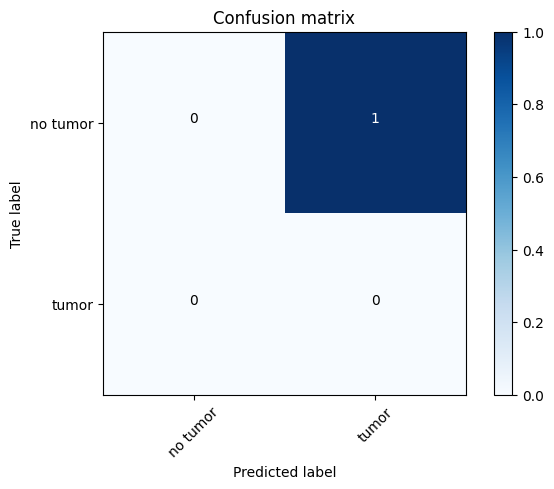

In [ ]:
import itertools

target_names = ['no tumor', 'tumor']

# Plotting the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = (confusion_matrix(y_test, y_pred))

np.set_printoptions(precision=3)

plt.figure()

plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix')

plt.show()

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


In [ ]:
import pandas as pd

# Create a dataframe with y_test and y_pred
df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

# Save dataframe to a CSV file
df.to_csv('predictions.csv', index=False)

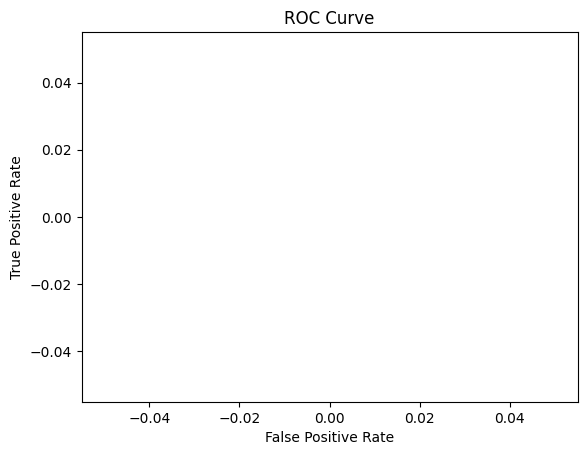

In [ ]:
plt.plot(fpr,tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()